In [1]:
import librosa
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM
from sklearn.metrics import accuracy_score, confusion_matrix
import os
from keras.utils import pad_sequences
from keras.layers import Reshape

In [2]:
# Download and extract the dataset
!wget https://www.dropbox.com/s/4jw31k5mlzcmgis/genres.tar.gz?dl=0 -O genres.tar.gz
!tar -xvf genres.tar.gz

DATASET_PATH = 'genres'

# Define genres and load data
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


--2024-08-09 04:13:38--  https://www.dropbox.com/s/4jw31k5mlzcmgis/genres.tar.gz?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/logv7hsjc1t3daaysuhyh/genres.tar.gz?rlkey=vcu3jvliyletkjwxz8bv8jm7c&dl=0 [following]
--2024-08-09 04:13:38--  https://www.dropbox.com/scl/fi/logv7hsjc1t3daaysuhyh/genres.tar.gz?rlkey=vcu3jvliyletkjwxz8bv8jm7c&dl=0
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc9f5739f4ccb035001ee3daaa2c.dl.dropboxusercontent.com/cd/0/inline/CYTYboMkdztLzGlWVuF0cUiZK243CshYrRduAQAoPrB8Lq3rnShJIhtFc-hUV6vhS3l5Y1s3Y6a0yTlQs_Fs4xyWCDwSUhV6xFS1snBp70BNQnrnWiOBHUf9esepP5Ikrt0/file# [following]
--2024-08-09 04:13:38--  https://uc9f5739f4ccb035001ee3daaa2c.dl.dropboxusercontent.com/cd/0/inline/CYTY

In [3]:

def load_audio_files(dataset_path, genres):
    X_list, y_list = [], []
    max_length = 173  # Maximum length of mfcc values
    for genre in genres:
        genre_path = os.path.join(dataset_path, genre)
        for file_name in os.listdir(genre_path):
            file_path = os.path.join(genre_path, file_name)
            y, sr = librosa.load(file_path)
            mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
            # Pad mfcc to maximum length
            mfcc = pad_sequences([mfcc.T], maxlen=max_length)[0].T
            # Reshape mfcc to a fixed shape
            mfcc = mfcc.reshape(-1, 40, max_length)
            X_list.append(mfcc)
            y_list.append(genres.index(genre))
    return np.array(X_list), np.array(y_list)
# Load dataset
X, y = load_audio_files(DATASET_PATH, genres)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_2d = X_train.reshape(X_train.shape[0], -1)
X_val_2d = X_val.reshape(X_val.shape[0], -1)
X_train_scaled = scaler.fit_transform(X_train_2d)
X_val_scaled = scaler.transform(X_val_2d)

# Reshape data for CRNN
X_train_reshaped = X_train_scaled.reshape(-1, 40, 173, 1)
X_val_reshaped = X_val_scaled.reshape(-1, 40, 173, 1)

# Define CRNN model architecture
input_layer = Input(shape=(40, 173, 1))
x = Conv2D(32, (3, 3), activation='relu')(input_layer)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Reshape((x.shape[1], 1))(x)  # Reshape to 3D array
x = LSTM(128, return_sequences=False)(x)
output_layer = Dense(10, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)

# Compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(X_train_reshaped, y_train, epochs=30, batch_size=32, validation_data=(X_val_reshaped, y_val))





Epoch 1/30
25/25 [==============================] - 259s 10s/step - loss: 2.3042 - accuracy: 0.0938 - val_loss: 2.3043 - val_accuracy: 0.0750
Epoch 2/30
25/25 [==============================] - 247s 10s/step - loss: 2.2796 - accuracy: 0.1100 - val_loss: 2.7178 - val_accuracy: 0.1000
Epoch 3/30
25/25 [==============================] - 253s 10s/step - loss: 2.2457 - accuracy: 0.1625 - val_loss: 2.2303 - val_accuracy: 0.1550
Epoch 4/30
25/25 [==============================] - 244s 10s/step - loss: 2.2011 - accuracy: 0.1850 - val_loss: 2.2639 - val_accuracy: 0.1500
Epoch 5/30
25/25 [==============================] - 238s 10s/step - loss: 2.1800 - accuracy: 0.1838 - val_loss: 2.1631 - val_accuracy: 0.1900
Epoch 6/30
25/25 [==============================] - 251s 10s/step - loss: 2.1427 - accuracy: 0.2050 - val_loss: 2.0871 - val_accuracy: 0.1950
Epoch 7/30
25/25 [==============================] - 248s 10s/step - loss: 2.2443 - accuracy: 0.1800 - val_loss: 2.4918 - val_accuracy: 0.1400
Epoch 

7/7 [==============================] - 11s 2s/step - loss: 1.9257 - accuracy: 0.2950
Validation loss: 1.926, Validation accuracy: 0.295
7/7 [==============================] - 12s 2s/step
[[ 5  3  4  0  0  1  0  4  2  1]
 [ 2  4  0  1  0  6  0  0  0  0]
 [ 5  0  7  3  1  1  0  3  1  6]
 [ 1  1  2  2  4  3  2  1  2  3]
 [ 1  0  0  3  4  0  0  2  1  4]
 [ 5  1  1  2  0 10  0  2  1  0]
 [ 0  0  1  4  1  0 16  0  0  3]
 [ 1  2  0  2  1  0  0  7  0  0]
 [ 3  0  3  3  1  1  1  6  3  2]
 [ 3  0  5  4  1  0  6  0  1  1]]
              precision    recall  f1-score   support

           0       0.19      0.25      0.22        20
           1       0.36      0.31      0.33        13
           2       0.30      0.26      0.28        27
           3       0.08      0.10      0.09        21
           4       0.31      0.27      0.29        15
           5       0.45      0.45      0.45        22
           6       0.64      0.64      0.64        25
           7       0.28      0.54      0.37      

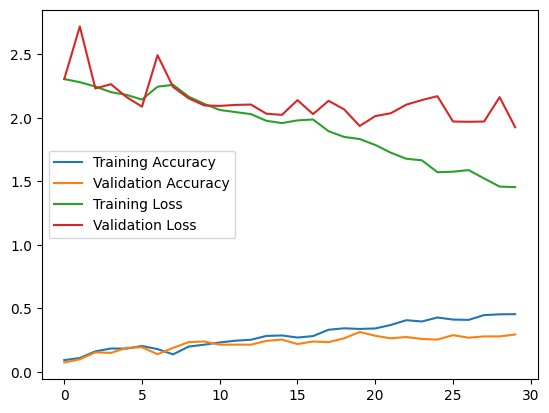

In [4]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
# Evaluation
loss, accuracy = model.evaluate(X_val_reshaped, y_val)
print(f'Validation loss: {loss:.3f}, Validation accuracy: {accuracy:.3f}')

# Confusion Matrix
y_pred = model.predict(X_val_reshaped)
y_pred_class = np.argmax(y_pred, axis=1)
y_val_class = y_val
conf_mat = confusion_matrix(y_val_class, y_pred_class)
print(conf_mat)

# Classification Report
print(classification_report(y_val_class, y_pred_class))

# Accuracy, Precision, Recall, F1-score
accuracy = accuracy_score(y_val_class, y_pred_class)
precision = precision_score(y_val_class, y_pred_class, average='weighted')
recall = recall_score(y_val_class, y_pred_class, average='weighted')
f1 = f1_score(y_val_class, y_pred_class, average='weighted')
print(f'Accuracy: {accuracy:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1-score: {f1:.3f}')

# Visualization
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()




In [5]:
from sklearn.metrics import accuracy_score

n_genres = 10  # Replace with the actual number of genres in your dataset

genre_accuracy = {}
for i in range(n_genres):
    genre_mask = y_val_class == i
    y_pred_genre = y_pred_class[genre_mask]
    y_true_genre = y_val_class[genre_mask]
    accuracy = accuracy_score(y_true_genre, y_pred_genre)
    genre_accuracy[i] = accuracy

print("Genre-wise accuracy:")
for i, accuracy in genre_accuracy.items():
    print(f"Genre {i}: {accuracy:.3f}")

Genre-wise accuracy:
Genre 0: 0.250
Genre 1: 0.308
Genre 2: 0.259
Genre 3: 0.095
Genre 4: 0.267
Genre 5: 0.455
Genre 6: 0.640
Genre 7: 0.538
Genre 8: 0.130
Genre 9: 0.048
